## Постановка задачи
Загрузим данные и разделим их на обучающие и проверочные в соотношении 80/20.

Используем Keras для построения нейросети с линейным, сверточными слоями и слоями подвыборки. Проверим, на что влияют различные функции активации сверточных слоев и какой оптимизатор обеспечивает наилучшую сходимость.

Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

### Подключение библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from skimage import io
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


### Используемые функции

In [2]:
image_x = 350
image_y = 525
image_ch = 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        x[j] = io.imread(os.path.join(filesDir, file))
    return np.array(x).reshape(len(df), image_x, image_y, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size   
            batch_end += batch_size

### Загрузка данных

In [23]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [24]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [25]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
12464                                                NaN  8dc43a0.jpg  Fish
20736  10 1390 1410 1390 2810 1390 4210 1390 5610 139...  eeba036.jpg  Fish
21120                                                NaN  f34fb69.jpg  Fish
14320  152330 3 152336 1 152344 192 153730 3 153736 2...  a4185ec.jpg  Fish
18736                                                NaN  d920035.jpg  Fish


### Функции активации
Логистическая функция (sigmoid) и гиперболический тангенс (tanh) похожи друг на друга и обеспечивают некоторую плавную сходимость обучения нейросети к нужному результату.

ReLU позволяет провести вычисления быстрее и использовать меньше итераций для обучения, но в случае неудачного выбора начальных коэффициентов возможно "выпадение" отдельных нейронов из слоев и ухудшение предсказательной силы всей нейросети.

![](activation.webp)

Последовательно проверим, как работает обучение при различных функциях активации для первых 50 изображений.

In [16]:
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), input_shape=(image_x, image_y, image_ch),
              strides=(2,2)),
        Activation("relu"),
        Conv2D(32, (3,3), strides=(2,2)),
        Activation("relu"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Activation("softmax"),
        Dense(1)
    ])
    return model

In [11]:
filesDir = "train_images_small"
batch_size = 10

Построим и обучим модель, используя адаптивный градиентный спуск и абсолютную ошибку.

In [17]:
model = create_model()
model.compile(optimizer="adam", loss="mean_absolute_error")

In [18]:
model.fit_generator(load_data(train[0:50], batch_size),
            epochs=10, steps_per_epoch=len(train[0:50])//batch_size,
            verbose=True)

Epoch 1/10
5/5 [==============================] - 5s 977ms/step - loss: 0.4216
Epoch 2/10
5/5 [==============================] - 4s 766ms/step - loss: 0.4194
Epoch 3/10
5/5 [==============================] - 4s 801ms/step - loss: 0.4172
Epoch 4/10
5/5 [==============================] - 4s 880ms/step - loss: 0.4157
Epoch 5/10
5/5 [==============================] - 4s 858ms/step - loss: 0.4138
Epoch 6/10
5/5 [==============================] - 4s 741ms/step - loss: 0.4121
Epoch 7/10
5/5 [==============================] - 4s 739ms/step - loss: 0.4106
Epoch 8/10
5/5 [==============================] - 4s 723ms/step - loss: 0.4088
Epoch 9/10
5/5 [==============================] - 4s 746ms/step - loss: 0.4076
Epoch 10/10
5/5 [==============================] - 4s 755ms/step - loss: 0.4058


### Оптимизаторы нейросети
![](optimizers.gif)
Проверим работу sgd, nadam, rmsprop. Выставим скорость обучения в 0,02

In [20]:
history = []
for optimizer in [optimizers.Nadam, optimizers.SGD, optimizers.RMSprop]:
    print (optimizer)
    model = create_model()
    model.compile(optimizer=optimizer(lr=0.02),
                 loss="mean_absolute_error")
    history.append(model.fit_generator(load_data(train[0:50], batch_size),
            epochs=10, steps_per_epoch=len(train[0:50])//batch_size,
            verbose=True).history["loss"])

<class 'keras.optimizers.Nadam'>
Epoch 1/10
5/5 [==============================] - 5s 930ms/step - loss: 0.4242
Epoch 2/10
5/5 [==============================] - 3s 695ms/step - loss: 0.4153
Epoch 3/10
5/5 [==============================] - 4s 733ms/step - loss: 0.4102
Epoch 4/10
5/5 [==============================] - 4s 702ms/step - loss: 0.3955
Epoch 5/10
5/5 [==============================] - 3s 698ms/step - loss: 0.3707
Epoch 6/10
5/5 [==============================] - 4s 711ms/step - loss: 0.3360
Epoch 7/10
5/5 [==============================] - 4s 716ms/step - loss: 0.3126
Epoch 8/10
5/5 [==============================] - 4s 722ms/step - loss: 0.2839
Epoch 9/10
5/5 [==============================] - 4s 708ms/step - loss: 0.2801
Epoch 10/10
5/5 [==============================] - 4s 712ms/step - loss: 0.2324
<class 'keras.optimizers.SGD'>
Epoch 1/10
5/5 [==============================] - 4s 882ms/step - loss: 0.4216
Epoch 2/10
5/5 [==============================] - 4s 721ms/step - 

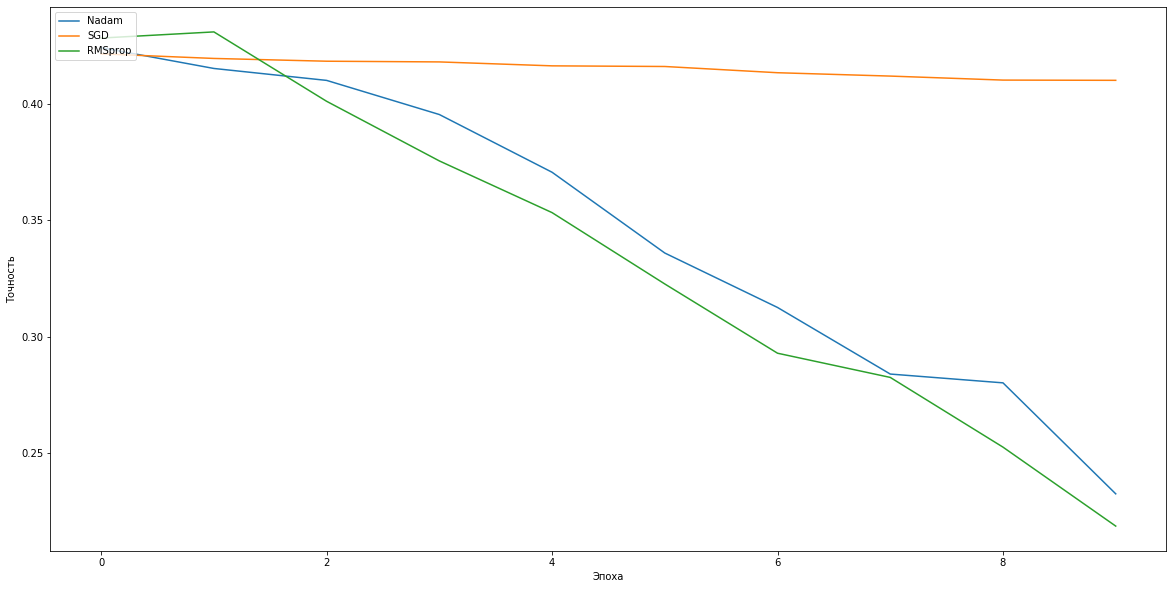

In [21]:
plt.figure(figsize=(20,10))
for i in range(len(history)):
    plt.plot(history[i])
plt.ylabel("Точность")
plt.xlabel("Эпоха")
plt.legend(["Nadam", "SGD", "RMSprop"], loc="upper left")
plt.show()